## ARI2204 – Reinforcement Learning

#### Isaac Muscat - 0265203L
#### Matthias Bartolo - 0436103L
#### Jerome Agius - 0353803L

# Packages

In [1]:
#Importing and installing necessary packages 
# !pip install matplotlib
# import time
# import queue
# import heapq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

In [2]:
PointsLookup={ "2":2, "3": 3, "4":4,"5":5,"6":6,"7":7,"8":8,"9":9,"10":10,"Q":10,"J":10,"K":10, "A":11}

In [3]:
cardsValue= {"A", "2","3", "4", "5", "6", "7", "8", "9", "10","J","Q","K"}
cardsSuit={"Diamonds", "Spades","Clubs","Hearts"}

In [4]:
print(PointsLookup)

{'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'Q': 10, 'J': 10, 'K': 10, 'A': 11}


In [5]:
#Function which calculates the total points given a number of cards
def GetTotalPoints(player):
    totalPoints=0
    for cards in player.hand:
        totalPoints+=PointsLookup[cards[1]]
        if cards[1] == "A" and player.hasAce:
            totalPoints-=10 
        elif cards[1] == "A" and not(player.hasAce):
            player.hasAce=True

    if(player.hasAce and totalPoints>21):
        totalPoints-=10
        player.hasAce=False
    return totalPoints

In [6]:
#Action 1 Hit
def Hit(player,cardDeck):
    card=cardDeck.pop(0)
    player.hand.append(card)

In [7]:
#Action 2 Stand
def Stand(player):
    player.stand=True

In [8]:
def CheckWin(player,dealer):
    if(dealer.stand and player.totalPoints==dealer.totalPoints):
        return 0
    elif(player.totalPoints==21):
        return  1
    elif(dealer.totalPoints==21):
        return -1
    elif(player.totalPoints>21):
        return -1
    elif(dealer.totalPoints>21):
        return  1
    elif(dealer.stand and player.totalPoints>dealer.totalPoints):
        return  1
    elif(dealer.stand and player.totalPoints<dealer.totalPoints):
        return  -1
    return None

In [9]:
class Player:
    def __init__(self):
        self.hand=list()
        self.totalPoints=0
        self.stand=False
        self.hasAce=False

In [10]:
def InitiateGame():
    cardDeck=list()
    player=Player()
    dealer=Player()
    
    for suit in cardsSuit:
        for value in cardsValue:
            cardDeck.append((suit,value))
    random.shuffle(cardDeck)
    
    Hit(player,cardDeck)
    Hit(player,cardDeck)
    Hit(dealer,cardDeck)
    Hit(dealer,cardDeck)
    player.totalPoints=GetTotalPoints(player)
    dealer.totalPoints=GetTotalPoints(dealer)
    return player,dealer,cardDeck

### MonteCarlo

In [11]:
def InitialiseQTable():
    Qtable=dict()

    for playerPoints in range(12,22):
        for dealerCard in range(2,12):
            for AceFlag in [True,False]:
                state=str(playerPoints)+","+str(dealerCard)+","+str(AceFlag)
                Qtable[state]={}
                for action in ["Hit","Stand"]:
                    Qtable[state][action]={"Values":0,"Count":0}#Initialisingn to 0
    return Qtable

In [12]:
Qtable=InitialiseQTable()

In [13]:
print(Qtable)

{'12,2,True': {'Hit': {'Values': 0, 'Count': 0}, 'Stand': {'Values': 0, 'Count': 0}}, '12,2,False': {'Hit': {'Values': 0, 'Count': 0}, 'Stand': {'Values': 0, 'Count': 0}}, '12,3,True': {'Hit': {'Values': 0, 'Count': 0}, 'Stand': {'Values': 0, 'Count': 0}}, '12,3,False': {'Hit': {'Values': 0, 'Count': 0}, 'Stand': {'Values': 0, 'Count': 0}}, '12,4,True': {'Hit': {'Values': 0, 'Count': 0}, 'Stand': {'Values': 0, 'Count': 0}}, '12,4,False': {'Hit': {'Values': 0, 'Count': 0}, 'Stand': {'Values': 0, 'Count': 0}}, '12,5,True': {'Hit': {'Values': 0, 'Count': 0}, 'Stand': {'Values': 0, 'Count': 0}}, '12,5,False': {'Hit': {'Values': 0, 'Count': 0}, 'Stand': {'Values': 0, 'Count': 0}}, '12,6,True': {'Hit': {'Values': 0, 'Count': 0}, 'Stand': {'Values': 0, 'Count': 0}}, '12,6,False': {'Hit': {'Values': 0, 'Count': 0}, 'Stand': {'Values': 0, 'Count': 0}}, '12,7,True': {'Hit': {'Values': 0, 'Count': 0}, 'Stand': {'Values': 0, 'Count': 0}}, '12,7,False': {'Hit': {'Values': 0, 'Count': 0}, 'Stand': {

In [14]:
def ArgMax(QTable, state):
    if(QTable[state]["Hit"]["Values"]>=QTable[state]["Stand"]["Values"]):
        return "Hit"
    else:
        return "Stand"

In [15]:
def PlayerPolicy1(player,dealer,cardDeck,stepNumber,epsilon,Qtable):
    action=None
    state=str(player.totalPoints)+","+str(PointsLookup[dealer.hand[0][1]])+","+str(player.hasAce)
    if player.totalPoints==21:
        Stand(player)
        action="Stand"
    elif player.totalPoints>11 and player.totalPoints<21:
        #With Exploration
        if(stepNumber==1):
            if(random.randint(0,1)==1):
                action="Hit"
                Hit(player,cardDeck)
                player.totalPoints=GetTotalPoints(player)
            else:
                action="Stand"
                Stand(player)
        else:
            if(random.random()<epsilon):
                if(random.randint(0,1)==1):
                    action="Hit"
                    Hit(player,cardDeck)
                    player.totalPoints=GetTotalPoints(player)
                else:
                    action="Stand"
                    Stand(player)
            else:#1-e
                bestAction=ArgMax(Qtable, state)
                if(bestAction=="Hit"):
                    action="Hit"
                    Hit(player,cardDeck)
                    player.totalPoints=GetTotalPoints(player)
                else:
                    action="Stand"
                    Stand(player)

    else:
        Hit(player,cardDeck)
        player.totalPoints=GetTotalPoints(player)
        action="Hit"
        state=None
    
    return [state,action]

In [16]:
def PlayerPolicy2(player,dealer,cardDeck,stepNumber,epsilon,Qtable):
    action=None
    state=str(player.totalPoints)+","+str(PointsLookup[dealer.hand[0][1]])+","+str(player.hasAce)
    if player.totalPoints==21:
        Stand(player)
        action="Stand"
    elif player.totalPoints>11 and player.totalPoints<21:
        if(random.random()<epsilon):
            if(random.randint(0,1)==1):
                action="Hit"
                Hit(player,cardDeck)
                player.totalPoints=GetTotalPoints(player)
            else:
                action="Stand"
                Stand(player)
        else:#1-e
            bestAction=ArgMax(Qtable, state)
            if(bestAction=="Hit"):
                action="Hit"
                Hit(player,cardDeck)
                player.totalPoints=GetTotalPoints(player)
            else:
                action="Stand"
                Stand(player)

    else:
        Hit(player,cardDeck)
        player.totalPoints=GetTotalPoints(player)
        action="Hit"
        state=None
    
    return [state,action]

In [17]:
def BlackJackRound(configBit,player, dealer,cardDeck,episode,Qtable):  
    checkWin=CheckWin(player,dealer)
    stepNumber=1
    stateaction=list()
    while True:
        player.stand=False
        dealer.stand=False
        
        if(configBit==1):
            stateactiontmp=PlayerPolicy1(player,dealer,cardDeck,stepNumber,1/episode,Qtable) 
        elif(configBit==2):
            stateactiontmp=PlayerPolicy2(player,dealer,cardDeck,stepNumber,1/episode,Qtable)
        elif(configBit==3):
            stateactiontmp=PlayerPolicy2(player,dealer,cardDeck,stepNumber,math.e**(-episode/1000),Qtable) 
        elif(configBit==4):
            stateactiontmp=PlayerPolicy2(player,dealer,cardDeck,stepNumber,math.e**(-episode/10000),Qtable) 
        
        stateaction.append(stateactiontmp)
        if player.stand is True and player.totalPoints<=21:
            while dealer.totalPoints<17:
                Hit(dealer,cardDeck)
                dealer.totalPoints=GetTotalPoints(dealer)
            Stand(dealer)
        
        checkWin=CheckWin(player,dealer)
        #print("\nPlayer: ",player.hand, " Total Points: ",player.totalPoints)
        #print("Dealer: ",dealer.hand, " Total Points: ",dealer.totalPoints)
        
        if(checkWin is not None):
            break
        stepNumber+=1
        
    return checkWin,stateaction

In [18]:
def DrawGraph(worstFitnessArray,bestFitnessArray,avgFitnessArray,generation,title):
    #Plotting the points with labels
    plt.plot(generation, worstFitnessArray, label = "Wins",color="green")
    plt.plot(generation, bestFitnessArray, label = "Draws",color="orange")
    plt.plot(generation, avgFitnessArray, label = "Losses",color="red")

    #Naming the x-axis
    plt.xlabel("Episodes")
    #Naming the y-axis
    plt.ylabel("Wins/Draws/Losses")

    #Giving a title to the graph
    plt.title("Wins/Draws/Losses vs Episodes "+title)
    #Displaying legend
    plt.grid(alpha=0.5)
    plt.legend(loc='upper right')
    #Displaying plot
    plt.show()

In [19]:
def DrawBarGraph(stateAction):
    fig, ax = plt.subplots(figsize =(16, 100))
 
    # Horizontal Bar Plot
    ax.barh(list(stateAction.keys()), list(stateAction.values()))
    ax.grid( color ='grey',alpha=0.2)
    ax.set_title('State Actions',color="blue")
    plt.ylim(-0.5,len(stateAction)-0.5)
    plt.show()

In [20]:
def CreateStrategyTable(qEstimatedValue):
    cols=["2","3","4","5","6","7","8","9","10","A"]
    emptyboard=np.zeros((9, 10) , dtype=str) 
    aceStrategyTable=pd.DataFrame(data=emptyboard,columns=cols)
    aceStrategyTable.index+=12#To make indexes start at 12

    noAceStrategyTable=pd.DataFrame(data=emptyboard,columns=cols)
    noAceStrategyTable.index+=12#To make indexes start at 12

    for q in qEstimatedValue:
        stateAction=q.split(",")
        xIndex=int(stateAction[0])-12
        yIndex=int(stateAction[1])-2
        if(stateAction[2]=="False" and int(stateAction[0])<21):
            if("Hit" not in qEstimatedValue[q].keys()):
                aceStrategyTable.values[xIndex,yIndex]="S"
            elif("Stand" not in qEstimatedValue[q].keys()):
                aceStrategyTable.values[xIndex,yIndex]="H"
            elif(qEstimatedValue[q]["Hit"]>qEstimatedValue[q]["Stand"]):
                aceStrategyTable.values[xIndex,yIndex]="H"
            else:
                aceStrategyTable.values[xIndex,yIndex]="S"
        elif(stateAction[2]=="True"and int(stateAction[0])<21):
            if("Hit" not in qEstimatedValue[q].keys()):
                noAceStrategyTable.values[xIndex,yIndex]="S"
            elif("Stand" not in qEstimatedValue[q].keys()):
                noAceStrategyTable.values[xIndex,yIndex]="H"
            elif(qEstimatedValue[q]["Hit"]>qEstimatedValue[q]["Stand"]):
                noAceStrategyTable.values[xIndex,yIndex]="H"
            else:
                noAceStrategyTable.values[xIndex,yIndex]="S"

    print("\033[1m BlackJack Strategy Table when player is using an Ace as 1 \033[0m")
    display(noAceStrategyTable)
    print("\033[1m BlackJack Strategy Table when player is using an Ace as 11\033[0m")
    display(aceStrategyTable)

In [21]:
def BarGraphAcrossConfigurations(titleList,uniqueStates,colour,xlabel,ylabel):
    plt.bar(titleList,uniqueStates,color=colour)
    plt.title(ylabel+" vs Different Configurations of: "+xlabel)
    plt.ylabel(ylabel)
    plt.xlabel("Different Configurations of: "+xlabel)
    plt.grid(alpha=0.17)
    plt.show()

In [22]:
def ObtainDealerAdvantage(wins,losses):
    w=sum(wins)/100000
    l=sum(losses)/100000
    dealerAdvantage=(l-w)/(l+w)
    return dealerAdvantage

In [23]:
def Game(configBit,episodes=100000):
    wins=list()
    drawslist=list()
    losses=list()
    episodeslist=list()
    qTableLookupList=list()
    Qtable=InitialiseQTable()
    stateAction=dict()
    playerWins,dealerWins,draws,reward=0,0,0,0
    rewardEpisode=0
    
    
    for episode in range(1,episodes+1):
        player,dealer,cardDeck=InitiateGame()
        checkWin,stateActionList=BlackJackRound(configBit,player, dealer,cardDeck,episode,Qtable)

        if(checkWin==1):
            playerWins+=1
            reward+=1
            rewardEpisode=1
        elif(checkWin==-1):
            dealerWins+=1
            reward-=1
            rewardEpisode=-1
        else:
            draws+=1
        #Updating Table
        #print(stateActionList)
        futureReward=0
        
        for stateaction in reversed(stateActionList):
            if(stateaction[0] is not None):
                futureReward+=rewardEpisode
                Qtable[stateaction[0]][stateaction[1]]["Count"]+=1
                Qtable[stateaction[0]][stateaction[1]]["Values"]+=float(1/Qtable[stateaction[0]][stateaction[1]]["Count"]*(futureReward-Qtable[stateaction[0]][stateaction[1]]["Values"]))
               
            
            key=str(stateaction[0])+","+str(stateaction[1])
            if(key  not in stateAction.keys() and stateaction[0] is not None):
                stateAction[key]=1
                qTableLookupList.append((stateaction[0],stateaction[1]))
            elif(stateaction[0] is not None):
                stateAction[key]+=1
        if(episode%1000==0):
            print("Episode: ",episode," Player Wins:",playerWins," Dealer Wins: ",dealerWins," Draws: ",draws, " Reward: ",reward)
            wins.append(playerWins)
            drawslist.append(draws)
            losses.append(dealerWins)
            episodeslist.append(episode)
            playerWins,dealerWins,draws,reward=0,0,0,0
    #print(Qtable)
    qEstimatedValue=dict()
    for q in qTableLookupList:
        if(q[0] not in qEstimatedValue.keys()):
            qEstimatedValue[q[0]]={q[1]:Qtable[q[0]][q[1]]["Values"]}
        else:
            qEstimatedValue[q[0]][q[1]]=Qtable[q[0]][q[1]]["Values"]
    return stateAction, wins,drawslist,losses,episodeslist,qEstimatedValue

In [24]:
uniqueStates=list()
dealerAdvantages=list()

In [25]:
stateAction,wins,draws,losses,episodeslist,qEstimatedValue=Game(1)
dealerAdvantage=ObtainDealerAdvantage(wins,losses)
dealerAdvantages.append(dealerAdvantage)

Episode:  1000  Player Wins: 367  Dealer Wins:  593  Draws:  40  Reward:  -226
Episode:  2000  Player Wins: 374  Dealer Wins:  575  Draws:  51  Reward:  -201
Episode:  3000  Player Wins: 361  Dealer Wins:  586  Draws:  53  Reward:  -225
Episode:  4000  Player Wins: 351  Dealer Wins:  599  Draws:  50  Reward:  -248
Episode:  5000  Player Wins: 347  Dealer Wins:  598  Draws:  55  Reward:  -251
Episode:  6000  Player Wins: 361  Dealer Wins:  584  Draws:  55  Reward:  -223
Episode:  7000  Player Wins: 372  Dealer Wins:  576  Draws:  52  Reward:  -204
Episode:  8000  Player Wins: 394  Dealer Wins:  560  Draws:  46  Reward:  -166
Episode:  9000  Player Wins: 348  Dealer Wins:  593  Draws:  59  Reward:  -245
Episode:  10000  Player Wins: 370  Dealer Wins:  564  Draws:  66  Reward:  -194
Episode:  11000  Player Wins: 370  Dealer Wins:  579  Draws:  51  Reward:  -209
Episode:  12000  Player Wins: 386  Dealer Wins:  557  Draws:  57  Reward:  -171
Episode:  13000  Player Wins: 374  Dealer Wins:  

In [26]:
CreateStrategyTable(qEstimatedValue)

 BlackJack Strategy Table when player is using an Ace as 1 


2  3  4  5  6  7  8  9 10  A
12  S  H  S  H  S  S  H  S  S  S
13  S  S  H  S  S  S  S  S  S  S
14  S  S  S  H  H  H  S  S  S  H
15  S  H  H  S  S  H  S  S  S  S
16  S  S  S  H  S  S  S  S  S  S
17  S  S  H  H  S  S  S  S  S  S
18  S  S  S  H  S  S  S  S  S  S
19  S  S  S  S  S  S  S  S  S  S
20  S  S  S  S  S  S  S  S  S  S

 BlackJack Strategy Table when player is using an Ace as 11


2  3  4  5  6  7  8  9 10  A
12  H  S  H  S  S  S  H  S  S  H
13  H  H  H  S  S  H  H  S  S  S
14  S  H  S  S  H  H  H  H  S  H
15  S  S  S  S  S  H  H  H  S  H
16  S  S  S  S  S  H  H  H  H  H
17  S  S  S  S  S  S  H  S  S  S
18  S  S  S  S  S  S  S  S  S  S
19  S  S  S  S  S  S  S  S  S  S
20  S  S  S  S  S  S  S  S  S  S

In [27]:
uniqueStates.append(len(stateAction))
print("No of unique states: ",len(stateAction))
sortedActions1 = {k: v for k, v in sorted(stateAction.items(), key=lambda item: item[1])}
# for key,value in sortedActions1.items():
#     print("(",key,") appeared ",value," times")

No of unique states:  370


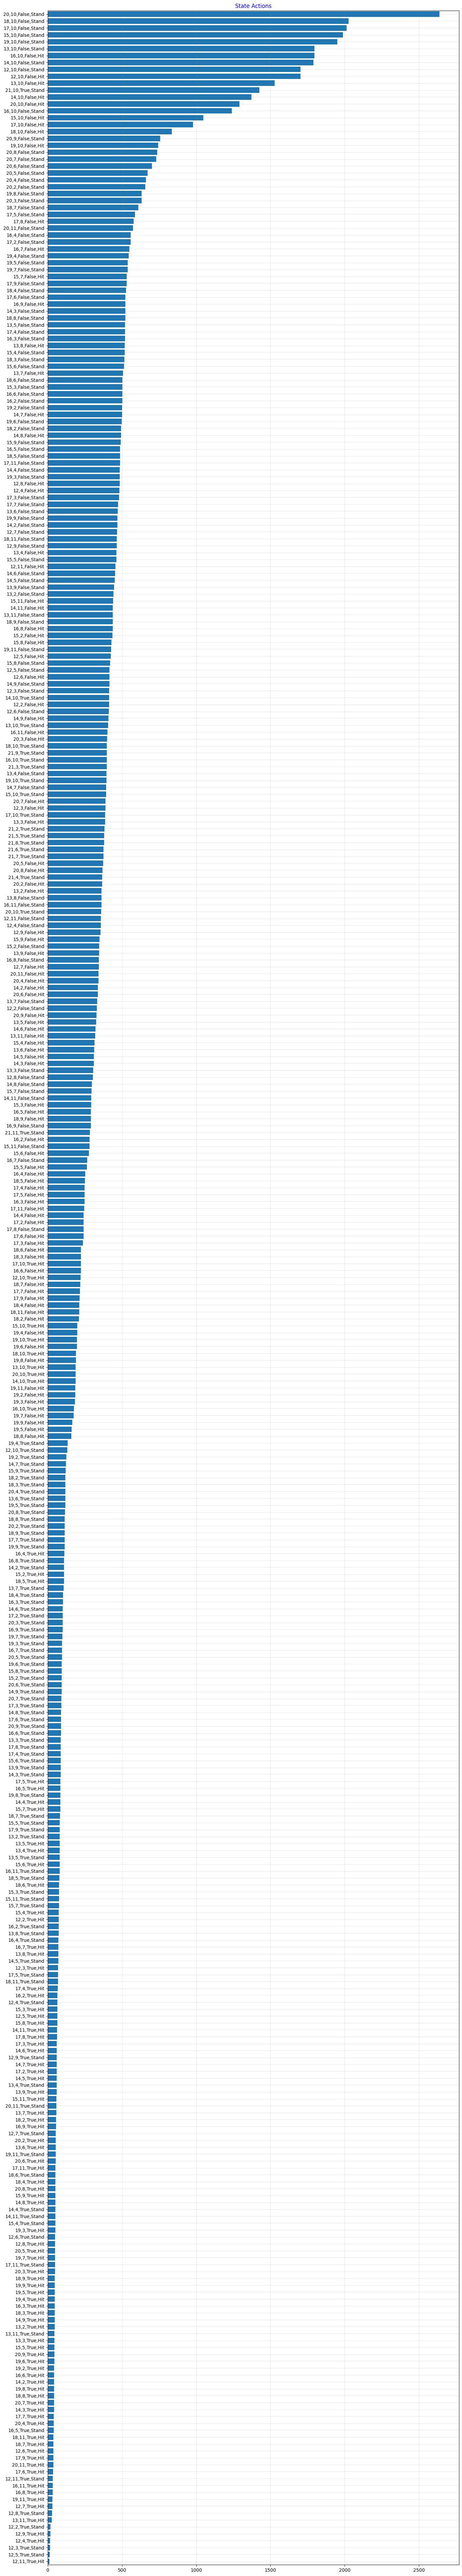

In [28]:
DrawBarGraph(sortedActions1)

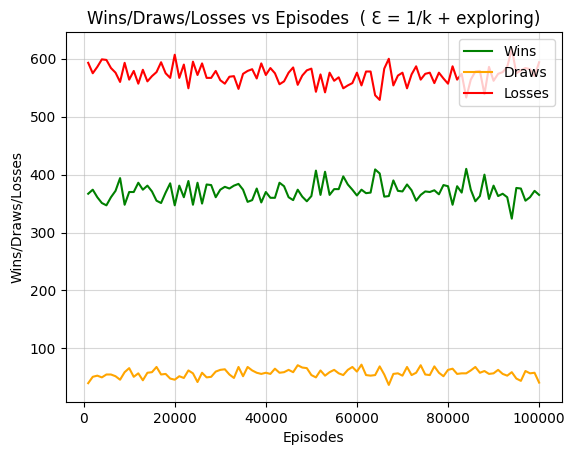

In [29]:
DrawGraph(wins,draws,losses,episodeslist," ( Ɛ = 1/k + exploring)")

In [30]:
stateAction,wins,draws,losses,episodeslist,qEstimatedValue=Game(2)
dealerAdvantage=ObtainDealerAdvantage(wins,losses)
dealerAdvantages.append(dealerAdvantage)

Episode:  1000  Player Wins: 397  Dealer Wins:  548  Draws:  55  Reward:  -151
Episode:  2000  Player Wins: 412  Dealer Wins:  523  Draws:  65  Reward:  -111
Episode:  3000  Player Wins: 377  Dealer Wins:  561  Draws:  62  Reward:  -184
Episode:  4000  Player Wins: 407  Dealer Wins:  532  Draws:  61  Reward:  -125
Episode:  5000  Player Wins: 394  Dealer Wins:  546  Draws:  60  Reward:  -152
Episode:  6000  Player Wins: 411  Dealer Wins:  534  Draws:  55  Reward:  -123
Episode:  7000  Player Wins: 381  Dealer Wins:  558  Draws:  61  Reward:  -177
Episode:  8000  Player Wins: 401  Dealer Wins:  525  Draws:  74  Reward:  -124
Episode:  9000  Player Wins: 406  Dealer Wins:  536  Draws:  58  Reward:  -130
Episode:  10000  Player Wins: 409  Dealer Wins:  538  Draws:  53  Reward:  -129
Episode:  11000  Player Wins: 416  Dealer Wins:  528  Draws:  56  Reward:  -112
Episode:  12000  Player Wins: 414  Dealer Wins:  527  Draws:  59  Reward:  -113
Episode:  13000  Player Wins: 393  Dealer Wins:  

In [31]:
CreateStrategyTable(qEstimatedValue)

 BlackJack Strategy Table when player is using an Ace as 1 


2  3  4  5  6  7  8  9 10  A
12  S  S  S  H  S  S  S  H  S  S
13  S  S  S  S  S  S  S  S  S  S
14  S  S  S  S  S  S  S  H  S  S
15  S  S  S  S  S  S  S  H  S  S
16  S  S  S  S  H  S  H  S  S  S
17  S  S  S  H  S  S  S  H  S  S
18  S  S  H  S  H  S  H  S  S  S
19  S  S  S  S  S  S  S  S  S  S
20  S  S  S  S  H  S  S  S  S  S

 BlackJack Strategy Table when player is using an Ace as 11


2  3  4  5  6  7  8  9 10  A
12  S  S  S  S  H  H  S  S  S  S
13  S  S  H  S  H  H  S  S  H  H
14  H  H  S  H  S  S  S  S  S  S
15  S  S  H  S  S  S  H  S  S  S
16  S  S  S  S  S  S  H  H  S  H
17  S  S  H  S  S  H  S  S  S  S
18  S  S  S  H  S  H  S  S  S  S
19  S  H  S  S  S  S  S  H  S  S
20  H  S  S  S  S  S  S  S  S  H

In [32]:
uniqueStates.append(len(stateAction))
print("No of unique states: ",len(stateAction))
sortedActions2 = {k: v for k, v in sorted(stateAction.items(), key=lambda item: item[1])}
# for key,value in sortedActions2.items():
#     print("(",key,") appeared ",value," times")

No of unique states:  367


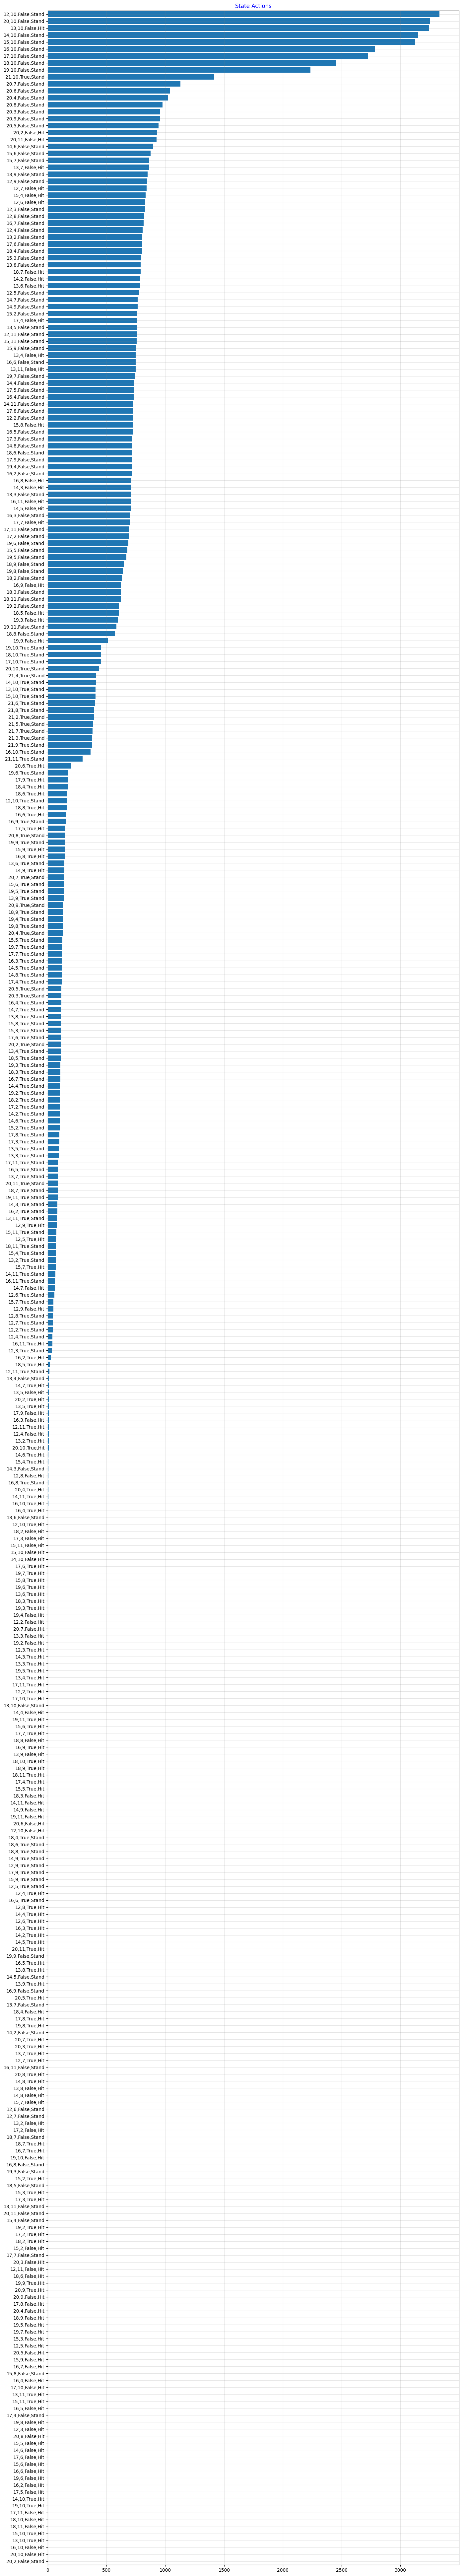

In [33]:
DrawBarGraph(sortedActions2)

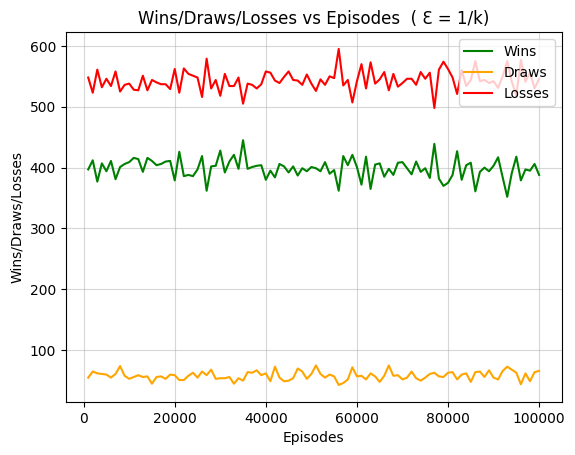

In [34]:
DrawGraph(wins,draws,losses,episodeslist," ( Ɛ = 1/k)")

In [35]:
stateAction,wins,draws,losses,episodeslist,qEstimatedValue=Game(3)
dealerAdvantage=ObtainDealerAdvantage(wins,losses)
dealerAdvantages.append(dealerAdvantage)

Episode:  1000  Player Wins: 354  Dealer Wins:  603  Draws:  43  Reward:  -249
Episode:  2000  Player Wins: 427  Dealer Wins:  532  Draws:  41  Reward:  -105
Episode:  3000  Player Wins: 428  Dealer Wins:  506  Draws:  66  Reward:  -78
Episode:  4000  Player Wins: 418  Dealer Wins:  499  Draws:  83  Reward:  -81
Episode:  5000  Player Wins: 447  Dealer Wins:  492  Draws:  61  Reward:  -45
Episode:  6000  Player Wins: 401  Dealer Wins:  522  Draws:  77  Reward:  -121
Episode:  7000  Player Wins: 452  Dealer Wins:  493  Draws:  55  Reward:  -41
Episode:  8000  Player Wins: 430  Dealer Wins:  501  Draws:  69  Reward:  -71
Episode:  9000  Player Wins: 411  Dealer Wins:  523  Draws:  66  Reward:  -112
Episode:  10000  Player Wins: 407  Dealer Wins:  527  Draws:  66  Reward:  -120
Episode:  11000  Player Wins: 430  Dealer Wins:  505  Draws:  65  Reward:  -75
Episode:  12000  Player Wins: 443  Dealer Wins:  506  Draws:  51  Reward:  -63
Episode:  13000  Player Wins: 399  Dealer Wins:  527  Dr

In [36]:
CreateStrategyTable(qEstimatedValue)

 BlackJack Strategy Table when player is using an Ace as 1 


2  3  4  5  6  7  8  9 10  A
12  S  S  S  S  S  S  H  S  S  H
13  S  S  H  S  S  S  S  S  S  S
14  S  S  H  S  H  S  S  S  S  H
15  S  S  H  S  S  S  S  S  S  S
16  S  H  S  H  S  S  S  S  S  S
17  H  H  S  S  S  S  S  S  S  S
18  S  S  S  S  S  S  S  S  S  S
19  S  S  S  S  S  S  S  S  S  S
20  S  S  S  S  H  S  S  S  S  S

 BlackJack Strategy Table when player is using an Ace as 11


2  3  4  5  6  7  8  9 10  A
12  S  S  H  S  S  H  S  H  S  S
13  S  H  S  S  H  H  H  H  H  S
14  S  S  H  S  S  H  S  H  S  H
15  S  S  S  H  S  H  H  H  S  H
16  S  S  S  S  S  S  S  S  H  H
17  S  H  S  S  S  H  H  H  S  S
18  H  S  S  S  S  S  S  S  S  S
19  S  S  S  S  S  S  S  S  S  S
20  S  S  S  S  S  S  S  S  S  S

In [37]:
uniqueStates.append(len(stateAction))
print("No of unique states: ",len(stateAction))
sortedActions3 = {k: v for k, v in sorted(stateAction.items(), key=lambda item: item[1])}
# for key,value in sortedActions3.items():
#     print("(",key,") appeared ",value," times")

No of unique states:  367


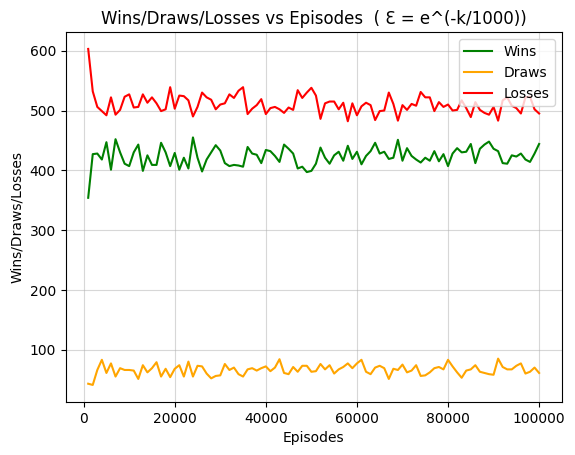

In [38]:
DrawGraph(wins,draws,losses,episodeslist," ( Ɛ = e^(-k/1000))")

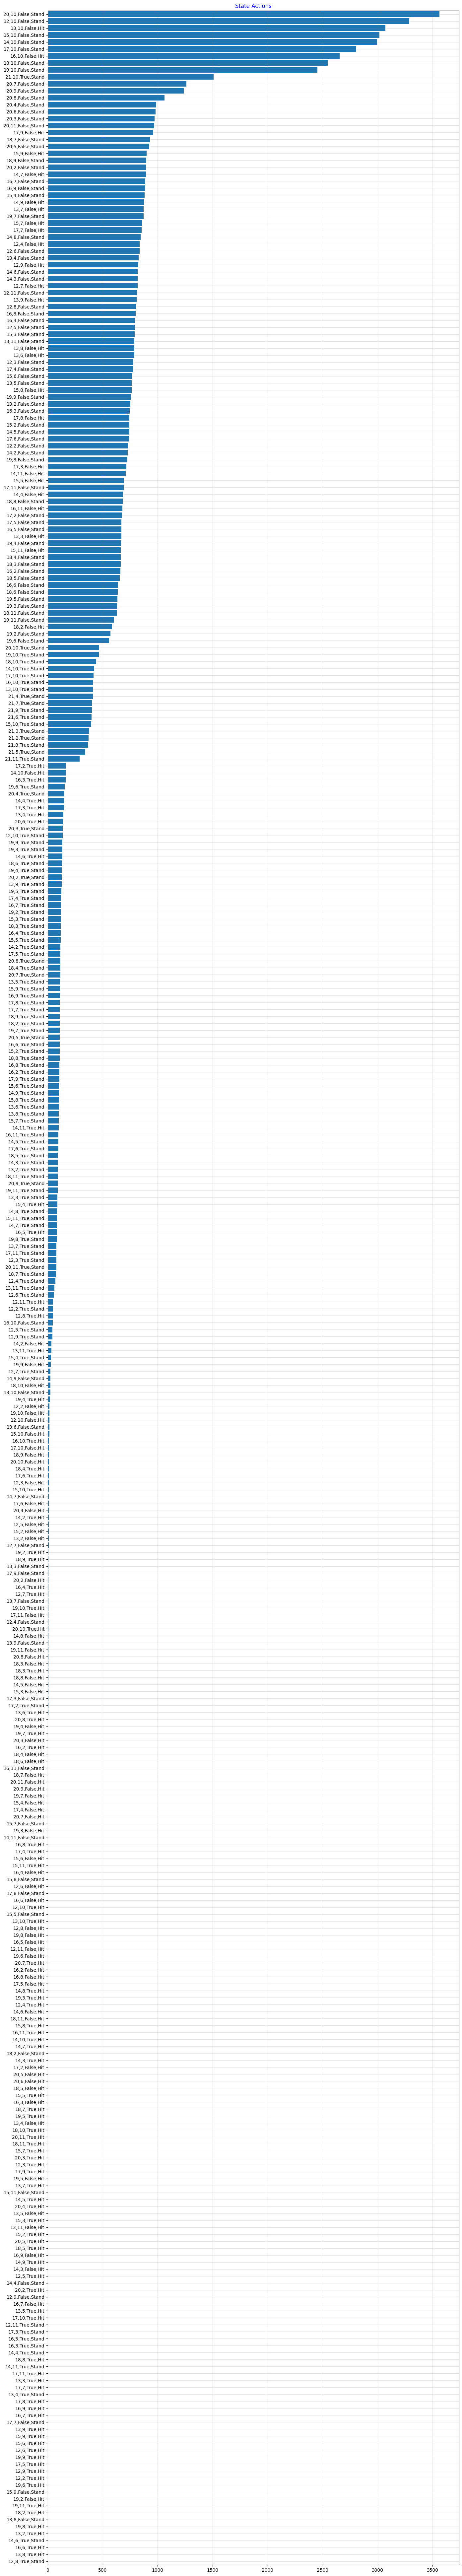

In [39]:
DrawBarGraph(sortedActions3)

In [40]:
stateAction,wins,draws,losses,episodeslist,qEstimatedValue=Game(4)
dealerAdvantage=ObtainDealerAdvantage(wins,losses)
dealerAdvantages.append(dealerAdvantage)

Episode:  1000  Player Wins: 330  Dealer Wins:  632  Draws:  38  Reward:  -302
Episode:  2000  Player Wins: 359  Dealer Wins:  594  Draws:  47  Reward:  -235
Episode:  3000  Player Wins: 340  Dealer Wins:  612  Draws:  48  Reward:  -272
Episode:  4000  Player Wins: 378  Dealer Wins:  580  Draws:  42  Reward:  -202
Episode:  5000  Player Wins: 372  Dealer Wins:  573  Draws:  55  Reward:  -201
Episode:  6000  Player Wins: 386  Dealer Wins:  567  Draws:  47  Reward:  -181
Episode:  7000  Player Wins: 397  Dealer Wins:  543  Draws:  60  Reward:  -146
Episode:  8000  Player Wins: 401  Dealer Wins:  542  Draws:  57  Reward:  -141
Episode:  9000  Player Wins: 376  Dealer Wins:  564  Draws:  60  Reward:  -188
Episode:  10000  Player Wins: 398  Dealer Wins:  539  Draws:  63  Reward:  -141
Episode:  11000  Player Wins: 413  Dealer Wins:  514  Draws:  73  Reward:  -101
Episode:  12000  Player Wins: 411  Dealer Wins:  527  Draws:  62  Reward:  -116
Episode:  13000  Player Wins: 425  Dealer Wins:  

In [41]:
CreateStrategyTable(qEstimatedValue)

 BlackJack Strategy Table when player is using an Ace as 1 


2  3  4  5  6  7  8  9 10  A
12  S  S  S  S  H  H  S  H  S  S
13  S  S  H  H  H  S  S  S  S  S
14  S  S  H  S  S  S  S  S  S  S
15  H  S  H  H  S  S  S  S  S  S
16  H  S  S  S  S  H  S  H  S  H
17  S  S  S  H  S  S  H  S  S  S
18  S  S  S  S  S  S  S  S  S  H
19  S  S  S  S  S  S  S  S  S  S
20  S  S  S  S  S  S  S  S  S  S

 BlackJack Strategy Table when player is using an Ace as 11


2  3  4  5  6  7  8  9 10  A
12  S  S  H  S  S  H  S  S  S  H
13  S  S  S  S  S  H  S  S  S  S
14  S  S  S  S  S  S  H  S  S  H
15  S  S  S  S  S  H  S  S  S  S
16  S  S  S  S  S  H  S  S  H  S
17  S  S  S  S  S  S  S  S  S  S
18  S  S  S  S  S  S  S  S  S  S
19  S  S  S  S  S  S  S  S  S  S
20  S  S  S  S  S  S  S  S  S  S

In [42]:
uniqueStates.append(len(stateAction))
print("No of unique states: ",len(stateAction))
sortedActions4 = {k: v for k, v in sorted(stateAction.items(), key=lambda item: item[1])}
# for key,value in sortedActions4.items():
#     print("(",key,") appeared ",value," times")

No of unique states:  370


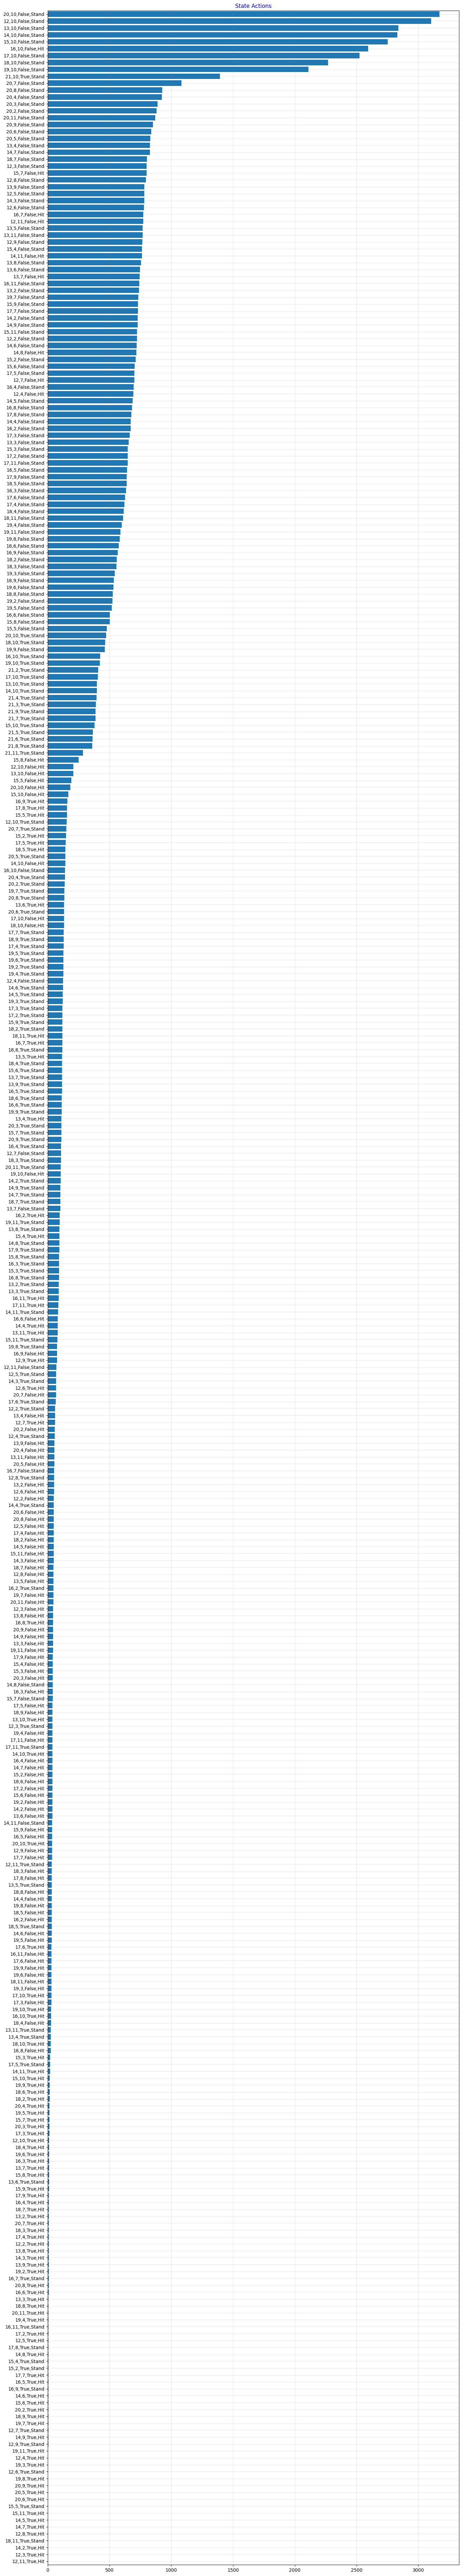

In [43]:
DrawBarGraph(sortedActions4)

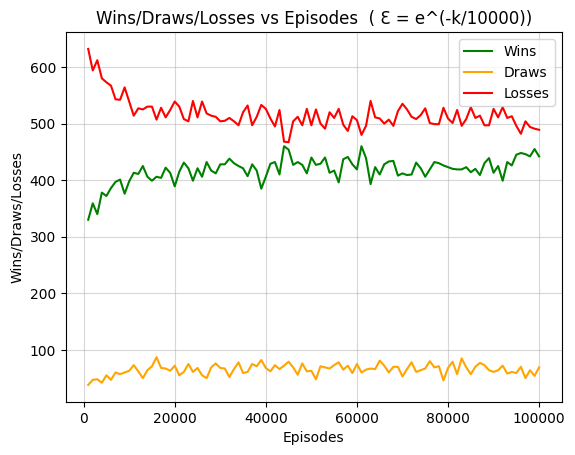

In [44]:
DrawGraph(wins,draws,losses,episodeslist," ( Ɛ = e^(-k/10000))")

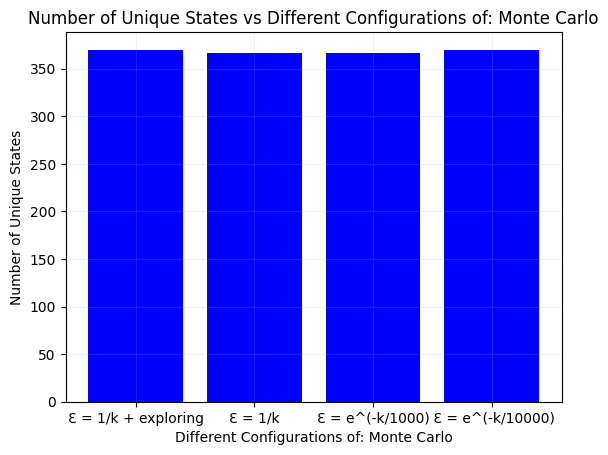

In [45]:
titleList=["Ɛ = 1/k + exploring","Ɛ = 1/k","Ɛ = e^(-k/1000)"," Ɛ = e^(-k/10000)"]
BarGraphAcrossConfigurations(titleList,uniqueStates,"blue","Monte Carlo","Number of Unique States")

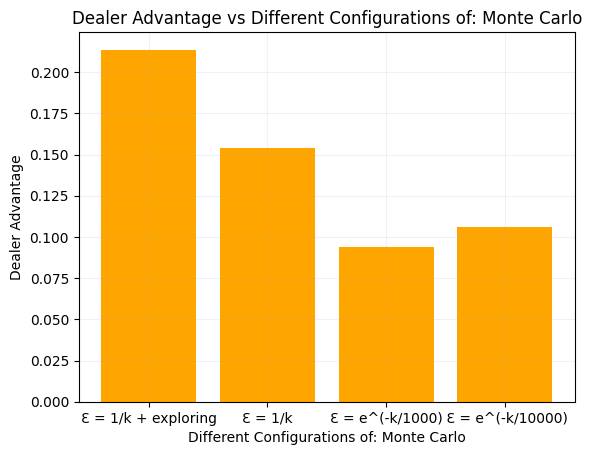

In [46]:
BarGraphAcrossConfigurations(titleList,dealerAdvantages,"orange","Monte Carlo","Dealer Advantage")

### Sarsa

In [47]:
uniqueStates=list()

In [48]:
#For Sarsa Algorithm
def TakeEpsilonPolicy(state, Qtable, epsilon):
    stateParams=state.split(",")
    if int(stateParams[0])==21:
        action="Stand"
    elif int(stateParams[0])>11 and int(stateParams[0])<21:
        if(random.random()<epsilon):
            if(random.randint(0,1)==1):
                action="Hit"
            else:
                action="Stand"
        else:#1-e
            bestAction=ArgMax(Qtable, state)
            if(bestAction=="Hit"):
                action="Hit"
            else:
                action="Stand"
    else:
        action="Hit"
        
    return action

In [49]:
#For SarsaMax algorithm
def TakeGreedyPolicy(state, Qtable):
    stateParams=state.split(",")
    if int(stateParams[0])==21:
        action="Stand"
    elif int(stateParams[0])>11 and int(stateParams[0])<21:
        bestAction=ArgMax(Qtable, state)
        if(bestAction=="Hit"):
            action="Hit"
        else:
            action="Stand"
    else:
        action="Hit"
    
    return action

In [150]:
def BlackJackRoundSarsa(configBit,sarsaConfigBit,player,dealer,cardDeck,episode,Qtable,maxSteps,learningRate):  
    epsilon=0
    checkWin=CheckWin(player,dealer)
    stateAction=list()
    
    if(configBit==1):
        epsilon=0.1
    elif(configBit==2):
        epsilon=1/episode
    elif(configBit==3):
        epsilon=math.e**(-episode/1000) 
    elif(configBit==4):
        epsilon=math.e**(-episode/10000)
        
    stepNumber=1  
    state=str(player.totalPoints)+","+str(PointsLookup[dealer.hand[0][1]])+","+str(player.hasAce) 
    action=TakeEpsilonPolicy(state, Qtable, epsilon)
    while stepNumber<maxSteps:    
        
        if(action=="Hit"):
            Hit(player,cardDeck)
            player.totalPoints=GetTotalPoints(player)
        else:
            Stand(player)
        
        if player.stand is True and player.totalPoints<=21:
            while dealer.totalPoints<17:
                Hit(dealer,cardDeck)
                dealer.totalPoints=GetTotalPoints(dealer)
            Stand(dealer)
        
        checkWin=CheckWin(player,dealer)
        reward=0
        if(checkWin==1):
            reward=1
        elif(checkWin==-1):
            reward=-1
        elif(checkWin==0):
            reward=0          
        
        
        newstate= str(player.totalPoints)+","+str(PointsLookup[dealer.hand[0][1]])+","+str(player.hasAce) 
        newaction=TakeEpsilonPolicy(newstate, Qtable, epsilon)
        
        if(state in Qtable.keys()):
            stateAction.append([state,action])
            Qtable[state][action]["Count"]+=1
            alpha=float(1/(Qtable[state][action]["Count"]+1))
    
        if(checkWin is None and state in Qtable.keys() and newstate in Qtable.keys()):
            if(sarsaConfigBit==1):
                Qtable[state][action]["Values"]+=float(alpha*(reward+learningRate*Qtable[newstate][newaction]["Values"]-Qtable[state][action]["Values"]))
            else:
                Qtable[state][action]["Values"]+=float(alpha*(reward+learningRate*Qtable[newstate][TakeGreedyPolicy(newstate, Qtable)]["Values"] -Qtable[state][action]["Values"]))
        elif(state in Qtable.keys()):#Terminal State
            Qtable[state][action]["Values"]+=float(alpha*(reward-Qtable[state][action]["Values"]))

        action=newaction
        state=newstate
        stepNumber+=1
        if(checkWin is not None):
            break
        
    return checkWin,stateAction

In [151]:
def GameSarsa(configBit,sarsaConfigBit,episodes, maxSteps,  learningRate):
    wins=list()
    drawslist=list()
    losses=list()
    episodeslist=list()
    qTableLookupList=list()
    Qtable=InitialiseQTable()
    stateAction=dict()
    playerWins,dealerWins,draws,reward=0,0,0,0
    
    
    
    for episode in range(1,episodes+1):
        #print("Episode",episode)
        player,dealer,cardDeck=InitiateGame()
        checkWin,stateActionList=BlackJackRoundSarsa(configBit,sarsaConfigBit,player, dealer,cardDeck,episode,Qtable,maxSteps,learningRate)

        if(checkWin==1):
            playerWins+=1
            reward+=1
        elif(checkWin==-1):
            dealerWins+=1
            reward-=1
        else:
            draws+=1
        
        for stateaction in stateActionList:
            key=str(stateaction[0])+","+str(stateaction[1])
            if(key  not in stateAction.keys() and stateaction[0] is not None):
                stateAction[key]=1
                qTableLookupList.append((stateaction[0],stateaction[1]))
            elif(stateaction[0] is not None):
                stateAction[key]+=1
        if(episode%1000==0):
            print("Episode: ",episode," Player Wins:",playerWins," Dealer Wins: ",dealerWins," Draws: ",draws, " Reward: ",reward)
            wins.append(playerWins)
            drawslist.append(draws)
            losses.append(dealerWins)
            episodeslist.append(episode)
            playerWins,dealerWins,draws,reward=0,0,0,0

    qEstimatedValue=dict()
    for q in qTableLookupList:
        if(q[0] not in qEstimatedValue.keys()):
            qEstimatedValue[q[0]]={q[1]:Qtable[q[0]][q[1]]["Values"]}
        else:
            qEstimatedValue[q[0]][q[1]]=Qtable[q[0]][q[1]]["Values"]

    return stateAction, wins,drawslist,losses,episodeslist,qEstimatedValue

In [206]:
stateAction,wins,draws,losses,episodeslist,qEstimatedValuee=GameSarsa(4,1,100000, 100,  1)

Episode:  1000  Player Wins: 333  Dealer Wins:  627  Draws:  40  Reward:  -294
Episode:  2000  Player Wins: 370  Dealer Wins:  579  Draws:  51  Reward:  -209
Episode:  3000  Player Wins: 326  Dealer Wins:  633  Draws:  41  Reward:  -307
Episode:  4000  Player Wins: 368  Dealer Wins:  565  Draws:  67  Reward:  -197
Episode:  5000  Player Wins: 377  Dealer Wins:  571  Draws:  52  Reward:  -194
Episode:  6000  Player Wins: 372  Dealer Wins:  573  Draws:  55  Reward:  -201
Episode:  7000  Player Wins: 386  Dealer Wins:  547  Draws:  67  Reward:  -161
Episode:  8000  Player Wins: 407  Dealer Wins:  535  Draws:  58  Reward:  -128
Episode:  9000  Player Wins: 388  Dealer Wins:  558  Draws:  54  Reward:  -170
Episode:  10000  Player Wins: 415  Dealer Wins:  515  Draws:  70  Reward:  -100
Episode:  11000  Player Wins: 402  Dealer Wins:  529  Draws:  69  Reward:  -127
Episode:  12000  Player Wins: 418  Dealer Wins:  517  Draws:  65  Reward:  -99
Episode:  13000  Player Wins: 382  Dealer Wins:  5

In [207]:
CreateStrategyTable(qEstimatedValue)

 BlackJack Strategy Table when player is using an Ace as 1 


2  3  4  5  6  7  8  9 10  A
12  S  S  S  S  H  H  S  H  S  S
13  S  S  H  H  H  S  S  S  S  S
14  S  S  H  S  S  S  S  S  S  S
15  H  S  H  H  S  S  S  S  S  S
16  H  S  S  S  S  H  S  H  S  H
17  S  S  S  H  S  S  H  S  S  S
18  S  S  S  S  S  S  S  S  S  H
19  S  S  S  S  S  S  S  S  S  S
20  S  S  S  S  S  S  S  S  S  S

 BlackJack Strategy Table when player is using an Ace as 11


2  3  4  5  6  7  8  9 10  A
12  S  S  H  S  S  H  S  S  S  H
13  S  S  S  S  S  H  S  S  S  S
14  S  S  S  S  S  S  H  S  S  H
15  S  S  S  S  S  H  S  S  S  S
16  S  S  S  S  S  H  S  S  H  S
17  S  S  S  S  S  S  S  S  S  S
18  S  S  S  S  S  S  S  S  S  S
19  S  S  S  S  S  S  S  S  S  S
20  S  S  S  S  S  S  S  S  S  S

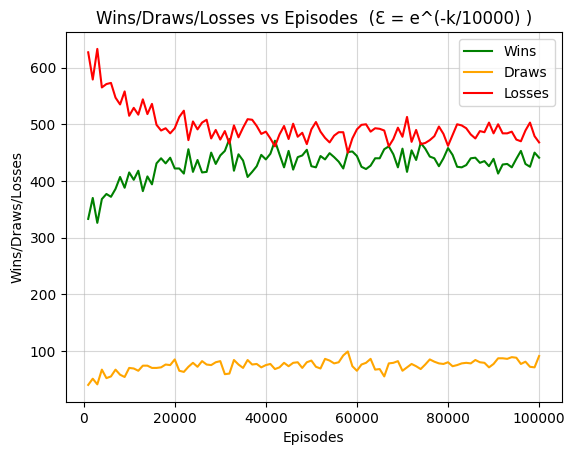

In [208]:
DrawGraph(wins,draws,losses,episodeslist," (Ɛ = e^(-k/10000) )")

In [185]:
uniqueStates.append(len(stateAction))
print("No of unique states: ",len(stateAction))
sortedActions5 = {k: v for k, v in sorted(stateAction.items(), key=lambda item: item[1])}
# for key,value in sortedActions4.items():
#     print("(",key,") appeared ",value," times")

No of unique states:  370


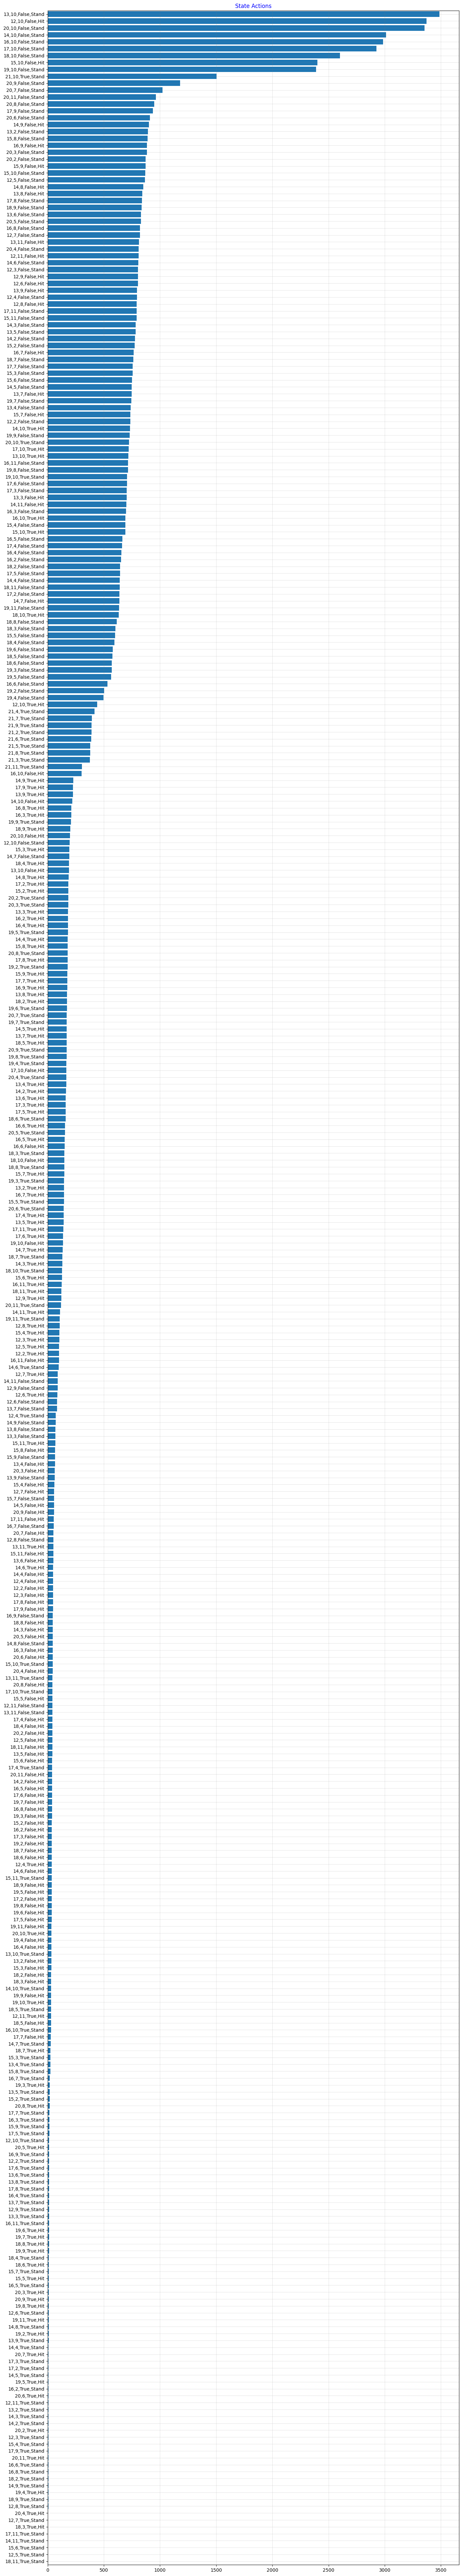

In [186]:
DrawBarGraph(sortedActions5)